## Redo tf-explain

2023-07-11
copy from tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc.ipynb

somehow can not found the 2020-08-xx works about MBTK who to show CAM for floods classificaion, so let's redo it for raw step!


In [50]:
%env TF_ENABLE_AUTO_MIXED_PRECISION=0

env: TF_ENABLE_AUTO_MIXED_PRECISION=0


2020-05-26 v1 LSW@NCHC

2020-08-13 v2


## BEGINNER
## Load and preprocess data
## Images

### TensorFlow > Learn > TensorFlow Core > Tutorials > Load images

本練習為TF官方範例，經中心同仁增加註解、練習、知識探索等，作為雲端平台的基礎教育課程使用。

(英文版用tf.data.Dataset.list_files與簡體版用from_tensor_slices作法各異)
- 英文版tf.data.Dataset.list_files 再用map產生 pair
- 簡體版from_tensor_slices 再用zip產生 pair 以及用map產生 pair'
- 簡體版增加了batch階段shuffle順序的差異說明
- 簡體版增加了餵tf.data到遷移學習進行訓練

### 2020-08-13
* 保留keras.data與tf.data兩種資料輸入方式
* 增加模型最終batch inference的結果32張+label(誤判標為紅字)繪圖
* 增加tf-explain，修改 raw Implementation熱力圖效果




### 2020-08-06 tf版本更新後造成先前範本無法運行

### 2020-08-07 使用<font color=#FF6600>tf 2.3</font>版可運行
* load_data/images教學有更新，加入tf.data split to train/valid/test方式，而且新版教學只能在tf2.3跑應該是跟改成one hot, tf.argmax有關。
- 另外NEU範例也發現只能在tf2.0運行，換成tf2.2 tf2.3即報錯， tf2.2還沒有image_dataset_from_directory可用，僅能用舊版ImageDataGenerator方式，而且tf2.3新範例使用tf.data one-hot argmax的方式，也無法用在tf2.2中。


- 由於現階段nvidia與twcc容器都尚未提供tf2.3，目前開發只能用colab，nb太燒cpu

2020-08-08 TF version PROBLEM!!!

tf-explain can not run with tf2.3 but tf2.2 is fine.
tf.data one-hot/argmax work with tf2.3 but NOT tf2.2.
workaround: (1)create tf.data in tf2.3, (2)train model in tf2.2 or 2.3, (3)then tf-explain in tf2.2!


### 2020-08-11 <font color=#FF6600>已修改get_label使得tf2.2可以運行</font>

應急做法
* 1.先在macos測試訓練與tf.explan後，再2.twcc cuda容器自行安裝tf2.3版使用，但tf-explain就分開另一個容器來處理。
* 2. 使用tf2.2版images.ipynb範例，修改ds處理，再補上訓練部分，與tf-explain。(ds跟訓練需要往回改且沒有參考不確定投下去能成功 除非ds就不使用tf.data用keras) (後來強制改寫get_label部分解決tf2.2在argmax的ds問題，後續再改訓練部份)

* 先測試自建tf2.3容器是否可行(TWCC 建立有問題無法pip到tf2.2 or 2.3)

### 2020-08-12 <font color=#FF6600>tf-explain version</font>
* Grad CAM is OK
* 作者function版本控制較多輸出較佳，tf-explan module not good to use
* Error Graph disconnected: 需要使用functional API重新包裝model，並且注意每層輸出/輸入變數要獨立不可重複沿用。

### 2020-08-25 <font color=#FF6600>tf-explain Graph disconnected</font>
* Graph disconnected: 當為base模型加入新的input layer發生。但追加在底部的dense, output layer卻不會造成影響。


### 2020-08-31 <font color=#FF6600>Move to 'clean NB' for trail, leave this NB for course used.</font>

###  For TWCC pkgs

In [51]:
# !sudo apt update

In [52]:
# !sudo apt-get install -y libsm6 libxrender1 libxext-dev tree unrar

In [53]:
!sudo pip3 install visual-logging ipyplot tf-explain


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


## 1. 下載到本機改為UNI範例

In [54]:
# import tensorflow as tf

# # 自動調節tf.data管道
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# import IPython.display as display
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import pathlib
# import cv2
# import vlogging

# print("tf version : ", tf.__version__)

# # 下載資料,(flower ~218MB)
# # keras下載位置預設為~/user/.keras/datasets/
# # !ls /Users/lsw/.keras/datasets/flower_photos
# # LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# # flood
# # origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# # data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# # flowers
# # origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# # data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)

# # uni
# data_dir = '/home/u3148947/.keras/datasets/uni'

# data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
# image_count = len(list(data_dir.glob('*/*.jpg')))
# CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
# # todo:這裡可以幫學員回憶python強大的表示式處理


# # data information
# print("Save to :", data_dir)
# print("Count images: ", image_count)
# print("Class names : ", CLASS_NAMES)

### 1. 下載flowers到本機

In [55]:
import tensorflow as tf

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging

print("tf version : ", tf.__version__)

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)

data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
# todo:這裡可以幫學員回憶python強大的表示式處理


# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", CLASS_NAMES)

tf version :  2.11.0
Save to : /home/u3148947/.keras/datasets/floods
Count images:  19622
Class names :  ['floods' 'normal' 'unknow']


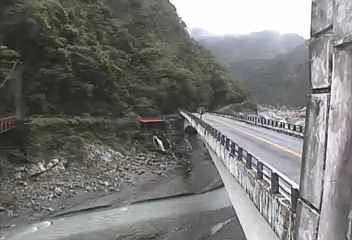

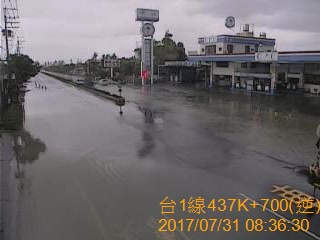

In [56]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('floods/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [57]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('roses/*'))

for image_path in roses[:1]:
    display.display(Image.open(str(image_path)))

In [58]:
# 檢查資料夾內圖片

tulips = list(data_dir.glob('tulips/*'))

for image_path in tulips[:1]:
    display.display(Image.open(str(image_path)))

In [59]:
# 檢查資料夾內圖片

tulips = list(data_dir.glob('ok/*'))

for image_path in tulips[:3]:
    display.display(Image.open(str(image_path)))

### 2.1 Load using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

目前讀取檔案方式很多（有點混亂），keras方式較簡單直覺，常見的前處理方法都可直接調整使用，對中小型資料集可以直接使用。除了效能上因為沒有平行處理，實際功能已經很足夠。

但最有效率的還是用2.2 tf.data因為對data有最佳化的讀取排程跟平行pipeline等功能。(見效能比較一節)

In [60]:
# 影像資料產生器：以batch為單位執行即時的資料擴增
# 例如 轉float[0.0~1.0] 標準化 翻轉 旋轉 縮放 亮度 等

# ImageDataGenerator : Generate batches of tensor image data with real-time data augmentation.
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [61]:
# 設定資料規格

BATCH_SIZE = 32
img_height = IMG_HEIGHT = 224
img_width = IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [62]:
# 資料產生器

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


# class_mode: "categorical", "binary", "sparse", "input" 預設為categorical==自動轉為one-hot標籤，
# 後面hit時檢查看看輸出類別為何？
# sparse就是原本的整數標籤0,1,2,etc.但後面的loss要同步改成sparse版本。

Found 19625 images belonging to 3 classes.


In [63]:

# Inspect a batch:

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

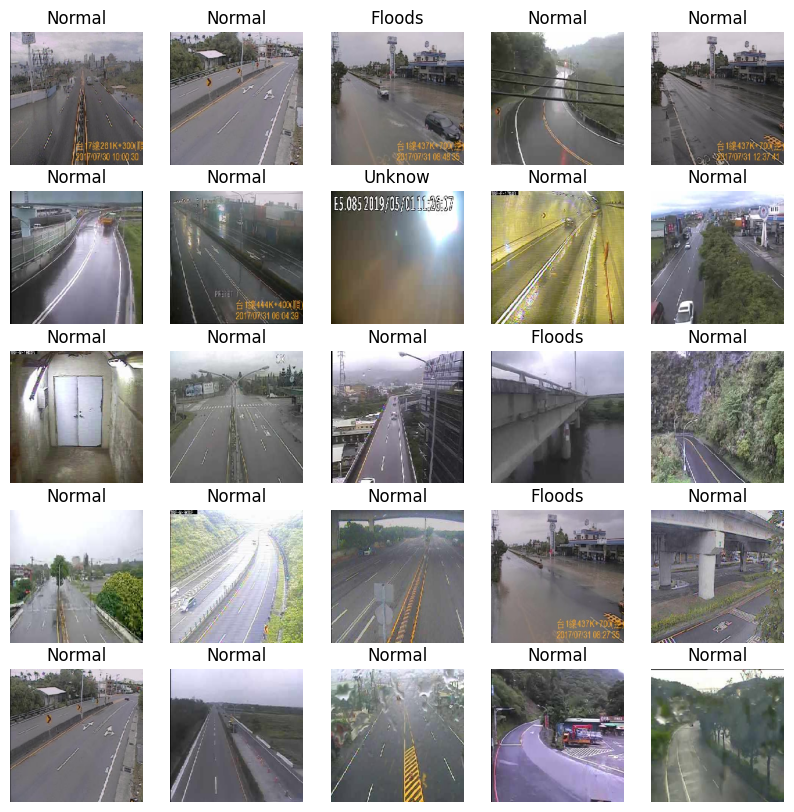

In [64]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#### hit:
- 圖片因為shuffle=True所以是隨機排列，如果試試看關掉會有什麼影響。
- target_size 一定要給嗎？如果原始圖大小不一怎麼辦？
- classes = list(CLASS_NAMES)是如何對應給每張圖的？

In [65]:
# 檢查batch數量與內容是否正確

print(len(label_batch))

32


In [66]:
CLASS_NAMES

array(['floods', 'normal', 'unknow'], dtype='<U6')

In [67]:
list(CLASS_NAMES)

['floods', 'normal', 'unknow']

In [68]:
# 注意！標籤在這裡已經‘自動’轉成one-hot格式。

"""
one-hot依照標籤在array的位置標示：

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

如：
roses <== ['roses', 0, 0, 0, 0]
[1., 0., 0., 0., 0.]

tulips <== [0, 0, 0, 0, 'tulips']
[0., 0., 0., 0., 1.]
"""

# 檢查batch標籤
label_batch



array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [69]:
# # 刪除本cell

# # 本段是tf.data的部分演示僅參考
# # 本實作是以load_data 以keras作法為主！ 


# images, labels = next(image_generator.flow_from_directory(data_dir))
# print(images.dtype, images.shape)
# print(labels.dtype, labels.shape)

# # 建立tf.data.Dataset
# # [flowers] is path of dataset, 
# ds = tf.data.Dataset.from_generator(
#     img_gen.flow_from_directory, args=[os.fspath(data_dir)], 
#     output_types=(tf.float32, tf.float32), 
#     output_shapes=([32,256,256,3], [32,5])
# )

# ds
# print(data_dir)
# print(data_dir)

# """ValueError: Attempt to convert a value (PosixPath('/Users/lsw/.keras/datasets/flower_photos')) 
# with an unsupported type (<class 'pathlib.PosixPath'>) to a Tensor.

# 這段要使用純路徑而不是用pathlib的物件！

# args=[data_dir] -> ['/Users/lsw/.keras/datasets/flower_photos']
# or
# args=[data_dir] -> [os.fspath(data_dir)]

# """


# # 本段是tf.data的部分演示僅參考
# # 本實作是以load_data 以keras作法為主！ 

# # 刪除本cell

### 2.2 Load using tf.data

(目前建議還是用tf.data)

使用tf.keras.preprocessing雖然簡便，但有三點短處(但已夠用了)：

* 較慢。參考後段Performance。
* 缺少細部控制。
* 與TF沒有很好的整合。




In [70]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""
# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))


# 2020-08-06 load_data/images 新版教學寫法並增加分離train/valid的方法
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [71]:
# 檢查路徑、檔案

for f in list_ds.take(5):
  print(f.numpy())

b'/home/u3148947/.keras/datasets/floods/normal/T17_266K200_0730_0014.jpg'
b'/home/u3148947/.keras/datasets/floods/normal/thbCCTV-17-062A-000-01_2019-05-01-10-47.jpg'
b'/home/u3148947/.keras/datasets/floods/floods/20170731073106074106_0021.jpg'
b'/home/u3148947/.keras/datasets/floods/normal/thbCCTV-26-014A-029-01_2019-05-01-11-08.jpg'
b'/home/u3148947/.keras/datasets/floods/floods/thbCCTV-52-0010-277-02_2019-05-01-10-57.jpg'


hit: 觀察有無shuffle變化

In [72]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['floods' 'normal' 'unknow']


hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [73]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [74]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

15701
3924


In [75]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/u3148947/.keras/datasets/floods/floods/thbCCTV-52-0010-277-02_2019-05-01-10-32.jpg' 

b'/home/u3148947/.keras/datasets/floods/normal/T17_266K200_0730_0014.jpg'
b'/home/u3148947/.keras/datasets/floods/floods/thbCCTV-12-009A-006-03_2019-01-30-10-05.jpg' 

b'/home/u3148947/.keras/datasets/floods/normal/thbCCTV-17-062A-000-01_2019-05-01-10-47.jpg'


In [76]:
#TODO
#J for train 60 /val 20 /test 20 , BTW the test set should be extracted from dataset before create train/val.
# val_size = int(image_count * 0.2)
# test_size = int(image_count * 0.2)

# train_ds = list_ds.skip(val_size+test_size)
# val_ds = list_ds.take(val_size)
# test_ds = list_ds.take(test_size)

# print(tf.data.experimental.cardinality(train_ds).numpy())
# print(tf.data.experimental.cardinality(val_ds).numpy())
# print(tf.data.experimental.cardinality(test_ds).numpy())

In [77]:
#TODO
# for t,v,s in zip(train_ds.take(2),val_ds.take(2),test_ds.take(2)):
#   print(t.numpy(), '\n')
#   print(v.numpy())
#   print(s.numpy())

#### 2.2.1 Write a short function that converts a file path to an (img, label) pair:

* tf.strings.split
* tf.image.decode_jpeg
* tf.image.convert_image_dtype
* tf.image.resize
* tf.io.read_file


In [78]:
#J 2020-08-06 check why not works!
l = [False, False, True, False, False]
# l = [0,1,0,0,0]


num_l = np.array(l, dtype=np.int)
print(num_l)
"""[0 0 1 0 0]"""

num_n = tf.argmax(num_l)
print(num_n)
"""tf.Tensor(2, shape=(), dtype=int64)"""

import sys
tf.print('tensor value =',num_n, output_stream=sys.stderr)
"""tensor value = 2"""

num_v = int(tf.argmax(num_l))
print('label inst = ', num_v)
"""label inst =  2"""


[0 0 1 0 0]
tf.Tensor(2, shape=(), dtype=int64)
tensor value = 2
label inst =  2


/tmp/ipykernel_1615/2449761907.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_l = np.array(l, dtype=np.int)


'label inst =  2'

In [79]:
# 純tf函數轉換檔案路徑pair

#舊版：tf2.2
# 取得路徑並把資料夾名稱取出作為類別標籤
# def get_label(file_path):
#   # convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#   return parts[-2] == CLASS_NAMES
# # return CLASS_NAMES == parts[-2] # same result
"""Label:  [False False True False False]
to sparese: 0~4
to catgial: one-hot [0, 1, 0, 0, 0]

"""
# def get_label(file_path):
#   # convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#   boolen = parts[-2] == class_names #CLASS_NAMES 這裡要換成小寫的
#   print('boolen==', boolen, 'class_names', class_names)
#   one_hot = np.array(boolen, dtype=int)
#   print('one-hot==', one_hot)
#   return one_hot



# # 影像讀取、轉換、尺寸
# def decode_img(img):
#   # convert the compressed string to a 3D uint8 tensor
#   img = tf.image.decode_jpeg(img, channels=3)
# #   # Use `convert_image_dtype` to convert to floats in the [0,1] range. #取消轉換在這裡寫死，因為mbnet需要轉成[-1,1]
# #   img = tf.image.convert_image_dtype(img, tf.float32)
#   # resize the image to the desired size.
#   return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

# # 產生影像,類別pair
# def process_path(file_path):
#   label = get_label(file_path)
#   # load the raw data from the file as a string
#   img = tf.io.read_file(file_path)
#   img = decode_img(img)
#   return img, label



#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)



#tf2.3 ok run
# def get_label(file_path):
#   # convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#   one_hot = parts[-2] == class_names
#   # Integer encode the label
#   return tf.argmax(one_hot) #error argmax無法處理bool，因為one-hot跟舊版一樣
"""
in tf2.3 retrun a <tf.Tensor: shape=(), dtype=int64, numpy=2>
the "2" is class_name[]'s 2.

With some modify code for tf2.2 to fix argmax issue:
in tf2.2 retrun a <tf.Tensor: shape=(), dtype=int64, numpy=2>
same as tf2.3 but geting error at data.map()
"""

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

#### 2.2.1 Use Dataset.map to create a dataset of image, label pairs:

hit:map作法



In [80]:
#舊版：tf2.2

# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# for image, label in labeled_ds.take(1):
#   print("Image shape: ", image.numpy().shape)
#   print("Label: ", label.numpy())


In [81]:
#新版：tf2.3

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


In [82]:
for image, label in train_ds_map.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

"""tf2.3
Image shape:  (224, 224, 3)
Label:  2"""

Image shape:  (224, 224, 3)
Label:  0


'tf2.3\nImage shape:  (224, 224, 3)\nLabel:  2'

hit: 標籤已自動轉成布林值，請自行設計一段標籤檢查碼。

<應該把小練習、小探索部分單獨放在最後!!!!!!!>

get_label('/Users/lsw/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([ True, False, False, False, False])>

In [83]:
#sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

# get_label('/Users/lsw/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')
get_label('/home/u3148947/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')

one_num: tf.Tensor(0, shape=(), dtype=int64)


<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [84]:
# [img, label] = process_path('/Users/lsw/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')
[img, label] = process_path('/home/u3148947/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')
print('label =', label)
tf.print(label)

one_num: tf.Tensor(0, shape=(), dtype=int64)
label = tf.Tensor(0, shape=(), dtype=int64)
0


In [85]:
# 參考

"""CLASS_NAMES的轉變

原本的CLASS_NAMES在讀取階段就以np array儲存，因此這裏很簡潔地使用array == 運算達到轉換成布林值格式。

==運算的意思是：比對array中全部元素的值，如果值相同該元素位置為True反之為False，最終返回一個相同大小的bool的array。

這個做法常在np或OpenCV做影像遮罩的時候使用，像是取二值化遮罩把128閾值設成 mask_img = img[<128]。
"""

def get_label_check(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
    
  print("parts\n", parts)
    
  # The second to last is the class-directory
  return parts[-2] == class_names

label_name_t = get_label_check('/Users/lsw/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')
print("label_name_t\n", label_name_t)

parts
 tf.Tensor(
[b'' b'Users' b'lsw' b'.keras' b'datasets' b'flower_photos' b'roses'
 b'9353111163_7a89b2df35_n.jpg'], shape=(8,), dtype=string)
label_name_t
 tf.Tensor([False False False], shape=(3,), dtype=bool)


In [86]:
# 參考
# 測試array比對運算
labels = np.array([1,2,0,0,2])
labels

array([1, 2, 0, 0, 2])

In [87]:
labels == 0

array([False, False,  True,  True, False])

In [88]:
labels_mask = [labels==0]

In [89]:
labels_mask

[array([False, False,  True,  True, False])]

todo:這段小練習可以跟OpenCV、Numpy一起複習，挑十行以內的遮罩範例。

#### TODO Standardize the data https://www.tensorflow.org/tutorials/load_data/images

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [90]:
# TODO
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

## 3. 使用tf.data訓練模型
### Basic methods for training

To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be added using the tf.data API. For more details, see the Input Pipeline Performance guide.
https://render.githubusercontent.com/guide/performance/datasets



hit: 基本套路 洗牌 batch 正規化


In [91]:

#J
#舊版：跟tf2.3版的教學範例有些差異，但可以運行(model.fit時 報錯跟repeat有關)

# def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#   # This is a small dataset, only load it once, and keep it in memory.
#   # use `.cache(filename)` to cache preprocessing work for datasets that don't
#   # fit in memory.
#   if cache:
#     if isinstance(cache, str):
#       ds = ds.cache(cache)
#     else:
#       ds = ds.cache()

#   ds = ds.shuffle(buffer_size=shuffle_buffer_size)

#   # Repeat forever
#   ds = ds.repeat()

#   ds = ds.batch(BATCH_SIZE)

#   # `prefetch` lets the dataset fetch batches in the background while the model
#   # is training.
#   ds = ds.prefetch(buffer_size=AUTOTUNE)

#   return ds

In [92]:
train_ds_map

<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

##### ds.cache(), representing the name of a directory on the filesystem to use for caching elements in this Dataset. If a filename is not provided, the dataset will be cached in memory.

In [93]:
#J
#新版：簡化很多
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# def configure_for_performance_cache(ds, cache=True):
#     if cache:
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache to file:", cache)
#         else:
#             ds = ds.cache()
#             print("Check cache in memory:", cache)
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds

hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [94]:
#J 舊版：
# train_ds_pre = prepare_for_training(train_ds_map)
# val_ds_pre = prepare_for_training(val_ds_map)

#J 新版：
train_ds_pre = configure_for_performance(train_ds_map)
val_ds_pre = configure_for_performance(val_ds_map)

#J 新版： + cache, but no good to use.
# train_chc = 'uni_train.tfcache'
# valid_chc = 'uni_val.tfcache'
# train_ds_pre = configure_for_performance_cache(train_ds_map, cache=train_chc)
# val_ds_pre = configure_for_performance_cache(val_ds_map, cache=valid_chc)


#image_batch, label_batch = next(iter(train_ds_pre))

### 20200825 test cache to file need First call DS
原tf.data_Load and preprocess data_image_tf2.2.ipynb
經過timeit後才會產生file cache
但此處不works

要等到model.fit之後，真的使用到cache才會產生

In [95]:
# import time
# default_timeit_steps = 100

# def timeit(ds, steps=default_timeit_steps):
#   start = time.time()
#   it = iter(ds)
#   for i in range(steps):
#     batch = next(it)
#     if i%10 == 0:
#       print('.',end='')
#   print()
#   end = time.time()

#   duration = end-start
#   print("{} batches: {} s".format(steps, duration))
#   print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [96]:
# unch_train_ds_pre = configure_for_performance_cache(train_ds_map)

In [97]:
# timeit(unch_train_ds_pre)

In [98]:
# cach_train_ds_pre = configure_for_performance_cache(train_ds_map, cache="./uni-train.tfcache")

In [99]:
# timeit(cach_train_ds_pre)

In [100]:
# !ls -lh

### Visualize the data
You can visualize this dataset similarly to the one you created previously.

In [101]:
#J 舊版:無法運行
# # Inspect a batch:

# def show_batch(image_batch, label_batch):
#   plt.figure(figsize=(10,10))
#   for n in range(25):
#       ax = plt.subplot(5,5,n+1)
#       plt.imshow(image_batch[n])
#       plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
#       plt.axis('off')

# show_batch(image_batch.numpy(), label_batch.numpy())

label from label_batch: [0. 1. 0.]
label from label_batch: [0. 1. 0.]
label from label_batch: [1. 0. 0.]
label from label_batch: [0. 1. 0.]
label from label_batch: [0. 1. 0.]
label from label_batch: [0. 1. 0.]
label from label_batch: [0. 1. 0.]
label from label_batch: [0. 0. 1.]
label from label_batch: [0. 1. 0.]


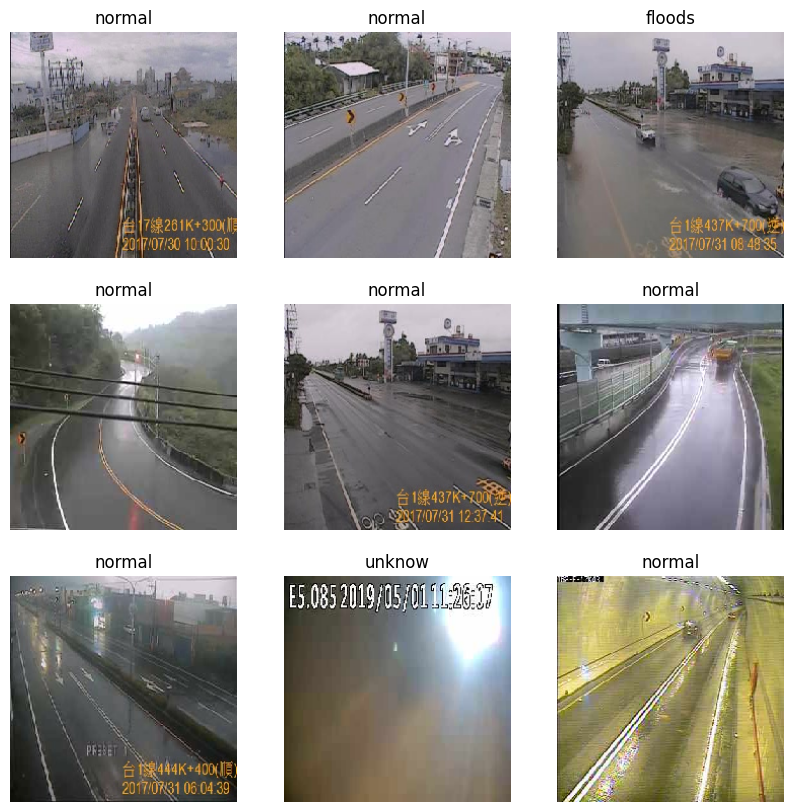

In [102]:
#J 新版：tf2.3

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")

In [103]:
#====================================================================================================#

###  A. training a simple model


In [104]:
# from tensorflow.keras import layers

# num_classes = 2

# model = tf.keras.Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Conv2D(32, 3, activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [105]:
# model.compile(
#   optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

In [106]:
# #在沒有給第一層輸入條件下，在buid、fit之前是無法使用summary功能的。
# model.summary()


In [107]:
# model.fit(
#   train_ds_pre,
#   validation_data=val_ds_pre,
#   epochs=1
# )

#### test model


In [108]:
# loss, accuracy = model.evaluate(val_ds_pre)
# print('Test accuracy :', accuracy)

### Predict on new data

https://www.tensorflow.org/tutorials/images/classification

* 這個模型僅到FC層不包含最後softmax，因此最後的分類結果要另外寫

In [109]:
# from tensorflow import keras

# #sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# #sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = keras.preprocessing.image.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

In [110]:
# """Downloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg
# 262144/261558 [==============================] - 1s 3us/step
# This image most likely belongs to sunflowers with a 61.29 percent confidence."""

# # 上面寫法會永遠保留第一次下載的影像，並且cache在.keras/datasets/Red_sunflower
# # 因此，要使用新的影像做測試，需要刪除原本的檔案即可
# !rm -rf ~/.keras/datasets/Red_sunflower


In [111]:
#====================================================================================================#

In [112]:
#====================================================================================================#

###  B. transfer learning with pretrained model

This scetion was modified from tf-transfer learning.ipynb example.


#### Use data augmentation

In [113]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

#### Rescale pixel values

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [114]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Create the base model from the pre-trained convnets

In [115]:
# IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

In [116]:
# # Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

This feature extractor converts each `244x244x3`(`160x160x3`) image into a `7x7x1280 ?` (`5x5x1280`) block of features. Let's see what it does to an example batch of images: (由於這個資料集製作時定為244了，這裡暫時沿用244不照範例來源。)

In [117]:
# image_batch, label_batch = next(iter(train_ds_pre))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)


In [118]:
# base_model.trainable = False

In [119]:
# # Let's take a look at the base model architecture
# base_model.summary()

### Add a classification head

In [120]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)



In [121]:
# #J: we used flower data, it has 5 labels
# num_classes = 5

# prediction_layer = tf.keras.layers.Dense(num_classes)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [122]:
# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

## revise above THREE cells!! 1 MobileNetV2

In [123]:
# #J try to revise to a more functional Model()!!!
# # revise above THREE cells!!

# # MobileNetV2: TODO!

# """This new model was added few bottom layer to base_mode, it can be trained and inference well. But will face the 
# `ValueError: Graph disconnected"""
# """10 epoch: val_accuracy: 0.8270 but should be ~0.94 as tutorial(val_ds_pre=26), val_ds_pre=23基數不同之誤差"""


# num_classes = 3

# inputs = tf.keras.Input(shape=(224, 224, 3))
# aug = data_augmentation(inputs)
# pre = preprocess_input(aug)

# bm_output = base_model(pre, training=False)

# gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output) 
# dro = tf.keras.layers.Dropout(0.2)(gap2d)
# outputs = tf.keras.layers.Dense(num_classes)(dro)

# model = tf.keras.Model(inputs, outputs, name='model-re-mbnetv2')
# #bm_output is a Tensor not a model.但這裏base_model.output似乎沒有包含inputs的訊息
# #並且這裏base_model.input 就已經bypass掉inputs層了，但tf.keras.Model(inputs, ...)一樣報Graph disconnected



# """直接移除 再回加 https://stackoverflow.com/questions/49546922/keras-replacing-input-layer
# 會無法存檔 infernce報錯等

# """


# # base_model._layers.pop(0) 

# # inputs = tf.keras.Input(shape=(224, 224, 3))
# # # aug = data_augmentation(inputs)
# # # pre = preprocess_input(aug)

# # bm_output = base_model(inputs, training=False)

# # gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output) 
# # dro = tf.keras.layers.Dropout(0.2)(gap2d)
# # outputs = tf.keras.layers.Dense(num_classes)(dro)

# # model = tf.keras.Model(inputs, outputs, name='model-re-mbnetv2')



# """問題出在inputlauer calss，他是代表一個模型的entry point，在外加一個input下產生兩個進入點認為是兩個分離的graph"""
# """新加的tf.keras.Input 在summary是以type = InputLayer，因此需要確認會不會與base model中的第一層InputLayer有關"""
# """As you can see, the model can be nested: a model can contain sub-models (since a model is just like a layer).
# 這個sub model (treat as A layer) worn't work for tf-explain. ？？？不確定因為有多inputlayer範例 且可以展開沒有問題！！！！
# """

# # num_classes = 5

# # inputs = tf.keras.Input(shape=(224, 224, 3))
# # aug = data_augmentation(inputs)
# # pre = preprocess_input(aug)

# # bm_output = base_model(pre, training=False)

# # gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output) 
# # dro = tf.keras.layers.Dropout(0.2)(gap2d)
# # outputs = tf.keras.layers.Dense(num_classes)(dro)

# # model = tf.keras.Model(inputs, outputs, name='model-re-mbnetv2')



# """在改一下邏輯試試看""" """目前是可以在pretrain model後(top)加layer但不能在前(bottom)加。"""
# """10 epoch: val_accuracy: 0.4636 沒真的加到aug/pre兩層"""

# # num_classes = 5

# # # inputs = tf.keras.Input(shape=(224, 224, 3))
# # aug = data_augmentation(base_model.input)
# # pre = preprocess_input(aug)

# # bm_output = base_model(pre, training=False)

# # gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output) 
# # dro = tf.keras.layers.Dropout(0.2)(gap2d)
# # outputs = tf.keras.layers.Dense(num_classes)(dro)

# # model = tf.keras.Model(base_model.input, outputs, name='model-re-mbnetv2')


# """把additational layer另外包成model再合併base_model，產出與原本外加bottom input layer一樣，沒有幫助"""

# # num_classes = 5

# # inputs = tf.keras.Input(shape=(224, 224, 3))
# # # aug = data_augmentation(inputs)
# # # pre = preprocess_input(aug)
# # rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5)(inputs)# no , offset= -1 in tf2.2

# # pre_model = tf.keras.Model(inputs, rescale, name='model-preprocess')


# # bm_output = base_model(rescale, training=False)

# # gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output) 
# # dro = tf.keras.layers.Dropout(0.2)(gap2d)
# # outputs = tf.keras.layers.Dense(num_classes)(dro)

# # model = tf.keras.Model(inputs, outputs, name='model-re-mbnetv2')

# # model_fusion = tf.keras.Model(pre_model.input, model.output, name='model-fusion-mbnetv2')

In [125]:
# model.summary()

In [126]:
# # Let's take a look at the base model architecture
# base_model.summary()

## revise above THREE cells!! 2 ResNet50

In [127]:
IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

# Create the base model from the pre-trained model MobileNetV2 ---> may to "ResNet50"
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [128]:
#J try to revise to a more functional Model()!!!
# revise above THREE cells!!

# ResNet50: Works!

num_classes = 3


# inputs = tf.keras.Input(shape=(224, 224, 3))
# bm_output = base_model(inputs, training=False)
gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(num_classes)(gap2d)

model = tf.keras.Model(base_model.input, outputs, name='model-re-resnet50')

In [129]:
# Let's take a look at the base model architecture
model.summary()

Model: "model-re-resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [130]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## TODO: base_model  summary same as re-build model? event the number of parameters!
#### 20230711 I think there is some misunderstanding, the Total papames and top-layer is sure different!

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [131]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#tf.losses.SparseCategoricalCrossentropy(from_logits=True) we are not used one-hot label.

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [132]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds_pre)

2023-07-11 15:57:54.965952: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xb62bd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-11 15:57:54.965991: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-07-11 15:57:55.051204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


  1/123 [..............................] - ETA: 17:02 - loss: 0.9937 - accuracy: 0.4375

2023-07-11 15:57:56.863819: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 [==============================] - 21s 103ms/step - loss: 0.9520 - accuracy: 0.5107


In [133]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.51


In [134]:
%%time
history = model.fit(train_ds_pre,
                    epochs=initial_epochs,
                    validation_data=val_ds_pre)

Epoch 1/10


2023-07-11 15:58:16.528821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


491/491 [==============================] - 51s 87ms/step - loss: 0.2779 - accuracy: 0.9140 - val_loss: 0.1654 - val_accuracy: 0.9559
Epoch 2/10
491/491 [==============================] - 21s 43ms/step - loss: 0.1356 - accuracy: 0.9636 - val_loss: 0.1209 - val_accuracy: 0.9684
Epoch 3/10
491/491 [==============================] - 21s 43ms/step - loss: 0.0990 - accuracy: 0.9738 - val_loss: 0.0853 - val_accuracy: 0.9758
Epoch 4/10
491/491 [==============================] - 20s 40ms/step - loss: 0.0795 - accuracy: 0.9801 - val_loss: 0.0742 - val_accuracy: 0.9814
Epoch 5/10
491/491 [==============================] - 20s 40ms/step - loss: 0.0670 - accuracy: 0.9843 - val_loss: 0.0595 - val_accuracy: 0.9860
Epoch 6/10
491/491 [==============================] - 20s 40ms/step - loss: 0.0578 - accuracy: 0.9859 - val_loss: 0.0532 - val_accuracy: 0.9893
Epoch 7/10
491/491 [==============================] - 20s 40ms/step - loss: 0.0507 - accuracy: 0.9875 - val_loss: 0.0460 - val_accuracy: 0.9896
Epo

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

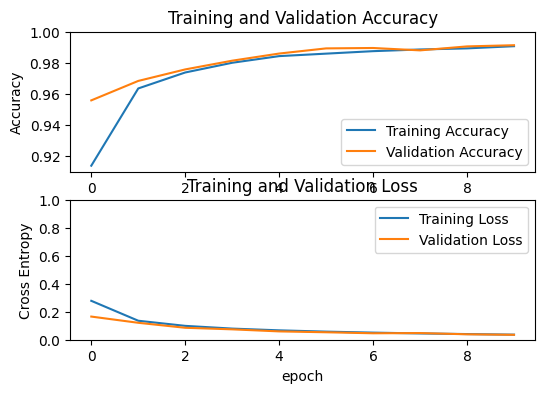

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning

### Un-freeze the top layers of the model

In [136]:
base_model.trainable = True

In [137]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10 #100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


HIT: RaseNet50 somehow展開模型後，使得base base model消失，因此使用上述方法對目前記憶體中的model是沒有作用的，

do: for layer in model.layer[:fine_tune_at]:
    layer,trainable = False
    
end: its because the "layer.trainable =  False" has one more space!! right is "layer.trainable = False"

### Compile the model (fine tuning)

In [138]:
model.compile(#loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),# adm -> RMSprop??
              metrics=['accuracy'])

In [139]:
model.summary()

Model: "model-re-resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [140]:
len(model.trainable_variables)

206

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [141]:
%%time
fine_tune_epochs = 10 #500
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds_pre,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds_pre)

Epoch 10/20
491/491 [==============================] - 82s 104ms/step - loss: 0.0486 - accuracy: 0.9847 - val_loss: 0.0083 - val_accuracy: 0.9977
Epoch 11/20
491/491 [==============================] - 48s 99ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0048 - val_accuracy: 0.9985
Epoch 12/20
491/491 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

2023-07-11 16:05:36.587189: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:342] ptxas warning : Registers are spilled to local memory in function 'fusion_904', 992 bytes spill stores, 452 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_905', 176 bytes spill stores, 176 bytes spill loads



491/491 [==============================] - 91s 185ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 13/20
491/491 [==============================] - 48s 98ms/step - loss: 4.6488e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 14/20
491/491 [==============================] - 48s 98ms/step - loss: 2.6101e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 15/20
491/491 [==============================] - 48s 98ms/step - loss: 2.6534e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9987
Epoch 16/20
491/491 [==============================] - 48s 98ms/step - loss: 1.5974e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9995
Epoch 17/20
491/491 [==============================] - 48s 98ms/step - loss: 1.5184e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 18/20
491/491 [==============================] - 48s 98ms/step - loss: 1.1869e-04 - accuracy: 1.0000 - val_loss: 0.

In [142]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

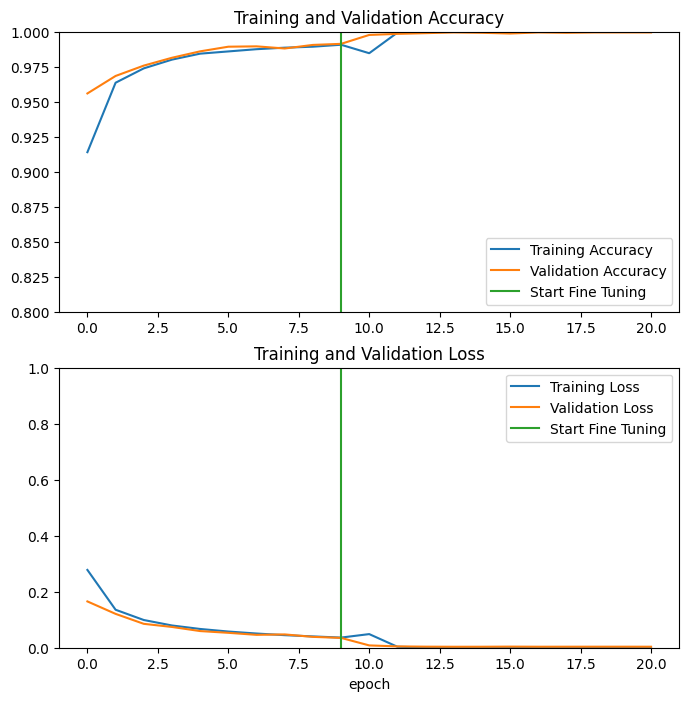

In [143]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

沒有另外製作test data，改用val測試

In [144]:
test_dataset = val_ds_pre
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

123/123 [==============================] - 4s 33ms/step - loss: 0.0036 - accuracy: 0.9995
Test accuracy : 0.9994903206825256


In [145]:
# image_batch, label_batch = val_ds_pre.take(1) ???? 

Predictions:
 [1 1 1 1 1 1 1 0 2 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]
Labels:
 [1 1 1 1 1 1 1 0 2 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]


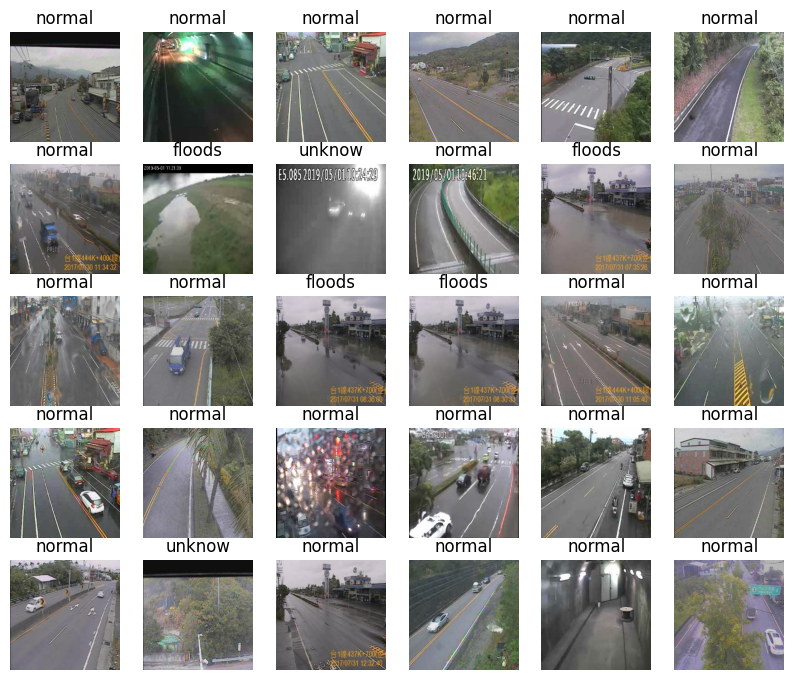

In [146]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) #J removed the (image_batch) of xx_batch(image_batch).flatten()
                                                  #J then, softmax/sigmoid is same, and key is argmax(L,1)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
predictions = tf.nn.softmax(predictions)#J try to fix the logts not correct?! but not works/
predictions = tf.where(predictions < 0.5, 0, 1) #J if less then 0.5 set to 0, else set to 1.
predictions = tf.argmax(predictions, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

  #org method
#   plt.title(class_names[predictions[i]])
    
  #J C method
  if predictions[i] == label_batch[i]:
      plt.title(class_names[predictions[i]])
  else:
      plt.title(class_names[predictions[i]],fontweight='bold', color='red')

  #J pythonic method 1
#   color = "green" if predictions[i] == label_batch[i] else "red"
#   plt.title(class_names[predictions[i]], color=color)

  #J pythonic method 2
#   plt.title(class_names[predictions[i]], color=("green" if predictions[i] == label_batch[i] else "red"))

  plt.axis("off")

In [147]:
#====================================================================================================#

### Save model


In [148]:
#Saving a Keras model:
# current_model_name = 'uni-cj0713-tf22-e60.h5'
current_model_name = 'floods-tf-explain-tf26-20230711-1600.h5'
model.save(current_model_name)

### Load model and inference

In [149]:
#Loading the model back:
model_back = tf.keras.models.load_model(current_model_name)

In [150]:
model_back.summary()

Model: "model-re-resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [151]:
#test load back model
model = model_back

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to normal with a 95.85 percent confidence.


In [152]:
"""Downloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg
262144/261558 [==============================] - 1s 3us/step
This image most likely belongs to sunflowers with a 61.29 percent confidence."""

# 上面寫法會永遠保留第一次下載的影像，並且cache在.keras/datasets/Red_sunflower
# 因此，要使用新的影像做測試，需要刪除原本的檔案即可
!rm -rf ~/.keras/datasets/Red_sunflower

In [153]:
#model.summary()

### tf.explan

#### 貌似跟模型有關，完整模型NN-Interpretability-tf2.ipynb(with TF2.2)是ＯＫ的 所以也有可能是tf版本問題

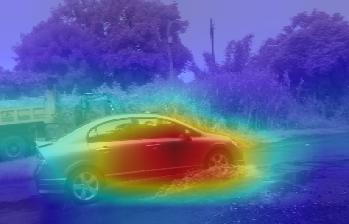

#### 2020-08-08 TF version PROBLEM!!!
* tf-explain can not run with tf2.3 but tf2.2 is fine.
* tf.data one-hot/argmax work with tf2.3 but NOT tf2.2.
* 
* workaround: (1)create tf.data in tf2.3, (2)train model in tf2.2 or 2.3, (3)then tf-explain in tf2.2!

In [154]:
#J tf-explain 對subgraph的模型無法處理，需要讀入後重新編成序列是模型
""" ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1_5:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_1". The following previous 
layers were accessed without issue: []

https://github.com/sicara/tf-explain/issues/138

略有不同，
ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_37:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_37". The following previous 
layers were accessed without issue: []
變成是mbv2本身第一層輸入無法連結，而不是外加的輸入處理。換模型測試避開mb特殊外加做法。

"""

model = tf.keras.models.load_model(current_model_name)
model.summary()

Model: "model-re-resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [156]:
#!pip3 install tf-explain

In [157]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.integrated_gradients import IntegratedGradients
# SmoothGrad, VanillaGradients cannot use lauer_anme



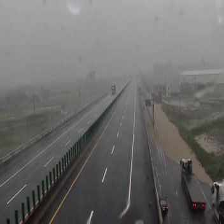
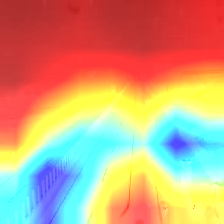


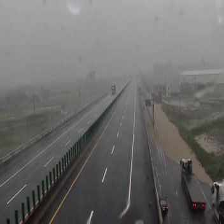
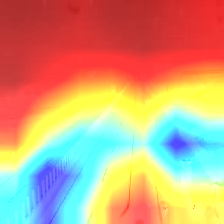

In [161]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
# 0,1,2,3,4

#tf-explain parameters
# IMAGE_PATH = 'imgs/6_1562059439000.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
IMAGE_PATH = 'imgs/C000163_2019-05-20-10-11.jpg'
IMAGE_PATH = 'imgs/20170731084112085112_0226.jpg'
IMAGE_PATH = 'imgs/thbCCTV-13-0610-038-01_2019-05-17-12-15.jpg'
LAYER_NAME = 'conv5_block3_out' #J if non given default is last 4D layer of model
# LAYER_NAME = None

# Load pretrained model or your own
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


#In memory model: just do not thing!
# model = in-memory-Model
#In memory model: just do not thing!


# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer

# explainer = OcclusionSensitivity()
# grid = explainer.explain(validation_data=data, model=model, patch_size=4, class_index=3) 


explainer = GradCAM()
grid = explainer.explain(data, model, colormap=cv2.COLORMAP_JET, image_weight=0.5, class_index=0)  # 281 is the tabby cat index in ImageNet

# explainer = GradCAM()
# grid = explainer.explain(validation_data=data, model=model, layer_name=LAYER_NAME, class_index=3)  # 281 is the tabby cat index in ImageNet

# explainer = SmoothGrad()
# grid = explainer.explain(validation_data=data, model=model, class_index=1)

# explainer = IntegratedGradients()
# grid = explainer.explain(validation_data=data, model=model, class_index=281) 
#479: 'car wheel',


#J 
#Save CAM image
out_name = 'tf-explain_GCAM_' + LAYER_NAME + '.png'
explainer.save(grid, ".", out_name)

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

# img_cam = cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(grid, cv2.COLOR_RGB2BGR)

ipyplot.plot_images([img_org, img_cam],['image', 'feature'], max_images=20, img_width=250)

## copy A. Grad CAM with raw Implementation

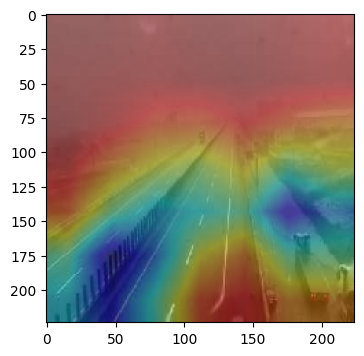

Q save to imgs/thbCCTV-13-0610-038-01_2019-05-17-12-15.jpg_GCAM_conv5_block3_out_CCI-0.png



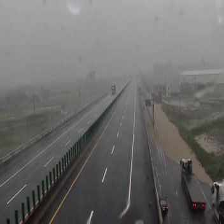
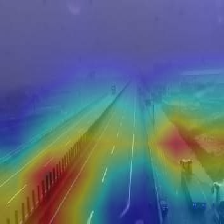


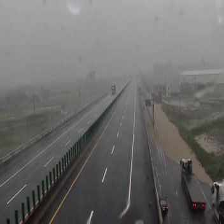
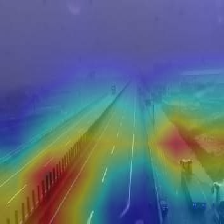

CAM for ID: 0
class_names: 0 ,1 , 2 
 ['floods' 'normal' 'unknow']


In [162]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = 'imgs/20170729083033084034_0017.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
IMAGE_PATH = 'imgs/20170731084112085112_0226.jpg'
IMAGE_PATH = 'imgs/thbCCTV-13-0610-038-01_2019-05-17-12-15.jpg'

LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out

""" imagenet1000_clsidx_to_labels.txt

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

281: 'tabby, tabby cat',
479: 'car wheel',

"""
CAM_CLASS_INDEX = 0 #479 #281 # CCI

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

#org
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAM_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)
output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

#Save CAM image
out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.png'
cv2.imwrite(out_name, output_image) # OK with RGB format

#Show it now
plt.figure(figsize=(4, 4))
plt.imshow(output_image)
# plt.title(out_name)
plt.show()
print(f"Q save to {out_name}")

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
# img_cam = output_image


ipyplot.plot_images([img_org, img_cam],['image', 'active'], max_images=20, img_width=224)
print("CAM for ID:", CAM_CLASS_INDEX)
print("class_names: 0 ,1 , 2 \n",  class_names)

# #J refunction this

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def GCAM(model, IMAGE_PATH, LAYER_NAME, img, CAM_CLASS_INDEX):

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, CAM_CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    # output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)
    output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

    #Save CAM image
    out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.jpg'
    cv2.imwrite(out_name, output_image) # OK with RGB format
    print("Save CAM to:", out_name)


    #return result image
    return output_image #cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)#somehow cv2 issue


In [ ]:
model = tf.keras.models.load_model(current_model_name)

IMAGE_PATH = 'imgs/20170731070105071105_0025.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for i in range(num_classes):
    tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
    p.append(tempimg)

ipyplot.plot_images([img.astype('uint8'), p[0], p[1], p[2]],['image', 'activeID-0', 'activeID-1', 'activeID-2'], max_images=20, img_width=224)
print("CAM for ID:", CAM_CLASS_INDEX)
print("class_names: 0 ,1 , 2 \n",  class_names)
print(type(p), np.array(p).shape)

In [ ]:
%%time

imgs_dir = pathlib.Path('okng/ng/')
imgs_list = list(imgs_dir.glob('*.jpg'))

model = tf.keras.models.load_model(current_model_name)
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for ip in imgs_list:
    print(ip)  
    IMAGE_PATH = str(ip)
    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    for i in range(num_classes):
        tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
        p.append(tempimg)

        
#TODO
# all_cam = [[GCAM(model,LAYER_NAME,img,CAM_CLASS_INDEX=i)] for i in range(num_classes) for path in imgs_list]



In [ ]:
('okng/ok/')
Wall time: 33min 42s
('okng/ng/')
Wall time: 45min 22s

### Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see Input Pipeline Performance.

To investigate, first here's a function to check the performance of our datasets:

In [ ]:
import time
default_timeit_steps = 100 #1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


Let's compare the speed of the two data generators:

In [ ]:
# `keras.preprocessing`
timeit(train_data_gen)


In [ ]:
# `tf.data`
timeit(train_ds)

A large part of the performance gain comes from the use of .cache.

In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:


In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

# 第一次cache會比較慢

In [ ]:
!ls -lh

In [ ]:
!ls -lh ~/.keras/dataset

In [ ]:
!ls -lah ~/.keras/datasets

In [ ]:
!du -sh ~/.keras/datasets/flower_photos

hit: 2.1G tf.data. cache的檔案似乎是原始檔案的九倍大。

## Reference:


* https://www.tensorflow.org/tutorials/load_data/tfrecord [如何製作TFRecord檔案/實作1]的原始碼與教學

* https://www.tensorflow.org/tutorials/load_data/images [實作2 flowers dataet] 主要原始碼
* https://www.tensorflow.org/guide/data [實作2 flowers dataet] 參考Create the image.ImageDataGenerator演示，但此演示較簡略僅參考未使用在本教學中
* http://medium.com/@lufor129/tensorflow-圖片數據增強-一-tfrecord-轉換-bd51a70277c  [實作2]的原始碼
* https://dotblogs.com.tw/shaynling/2017/11/20/150241 【Python】TensorFlow學習筆記(二)：初探 TFRecord 夏恩 [實作2]的原始碼


** 注意：如果是在有conda環境下，請注意啟動的環境是否正確。目前twcc+cntr+anaconda+base env.時，由於bashrc path直接導入base環境的pytroch，造成原有系統的tensorflow搜尋不到。請修改bashrc中的path路徑，或是根本上不要在base上安裝，要新建mytrochenv來分離安裝。